In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
# create the engine object
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [8]:
# look at Measurement object
session.query(Measurement).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2b38e1eb550>,
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0,
 'station': 'USC00519397'}

In [9]:
# look at Station object
session.query(Station).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2b38e1ebf98>,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716}

In [76]:
# get our range of measurment dates
session.query(func.min(Measurement.date),func.max(Measurement.date)).all()

[('2010-01-01', '2017-08-23')]

Text(0, 0.5, 'Precipitation (inches)')

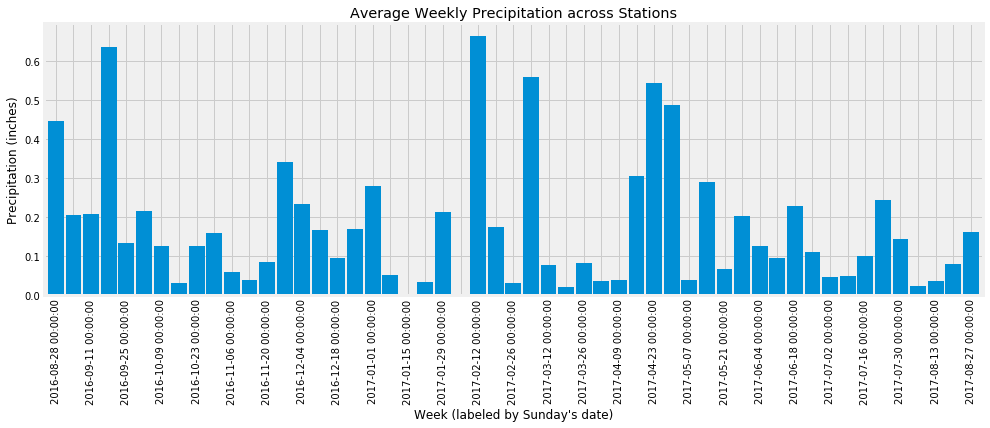

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
most_recent = session.query(func.max(Measurement.date)).all()
most_recent_df = datetime.strptime(most_recent[0][0],'%Y-%m-%d')
year_ago = most_recent_df - dt.timedelta(days = 365)
year_ago_str = year_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= year_ago_str).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
results_df = pd.read_sql(session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= year_ago_str).statement,session.bind)

# change of plans here—need a datetimeindex to resample by week for the plot
results_df['date_dt']= pd.to_datetime(results_df['date'])
results_df.set_index('date_dt',inplace = True)

# Sort the dataframe by date
sorted_df = results_df.sort_values('date_dt')
sorted_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
# use resample to average the prcp data by week
plot_data_df = pd.DataFrame(sorted_df['prcp'].resample('W').mean())

# create the plot
ax = plot_data_df.plot.bar(y='prcp',figsize=(15,5),legend=False,width=.9)

# hide every other tick label to clean up the x-axis a little
for i, t in enumerate(ax.get_xticklabels()):
    if (i % 2) != 0:
        t.set_visible(False)

# title and axes labels
ax.set_title('Average Weekly Precipitation across Stations')
ax.set_xlabel("Week (labeled by Sunday's date)")
ax.set_ylabel('Precipitation (inches)')



In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary_df = pd.DataFrame(results_df.describe()['prcp'])
summary_df.rename(columns={'prcp':'preciptation'},inplace=True)
summary_df


,preciptation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count()).group_by(Measurement.station).order_by(func.count().desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                                                            filter_by(station ='USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 1.0, 'WAIHEE 837.5, HI US observed temps\n from 2016-08-23 to 2017-08-23\nn=352 ')

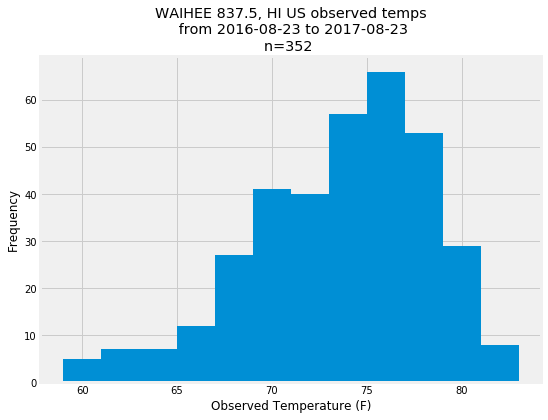

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station = 'USC00519281'
station_name = session.query(Station.name).filter(Station.station==station).all()

tobs = session.query(Measurement.tobs).filter(Measurement.date >= year_ago_str).filter(Measurement.station == station).all()
tobs_list = np.ravel(tobs)

plt.figure(figsize=(8,6))
plt.hist(tobs_list,bins=12)
plt.ylabel('Frequency')
plt.xlabel(f'Observed Temperature (F)')
plt.title(f'{station_name[0][0]} observed temps\n from {year_ago_str} to {most_recent[0][0]}\nn={len(tobs_list)} ')


In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
begin = '2017-04-01'
end = '2017-04-14'
results = calc_temps(begin, end)
results

[(67.0, 74.5, 82.0)]

Text(0.5, 1.0, 'Trip Avg Temp')

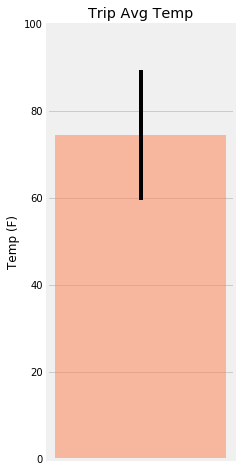

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmin = results[0][0]
tavg = results[0][1]
tmax = results[0][2]

plt.figure(figsize=(3,8))
plt.bar(['Avg Tmp'],tavg,yerr=tmax-tmin,color='coral',width=0.05,alpha=0.5)
plt.ylabel('Temp (F)')
plt.ylim([0,100])
plt.xticks('')
plt.title('Trip Avg Temp')


In [75]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)).\
    join(Station,Measurement.station==Station.station).group_by(Measurement.station).\
    filter(Measurement.date>=begin).filter(Measurement.date<=end).order_by(func.sum(Measurement.prcp).desc()).all()

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  4.85),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  3.76),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.19),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.8999999999999999),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.36),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.26),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0)]

# -------------Stopped here for now!--------------

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


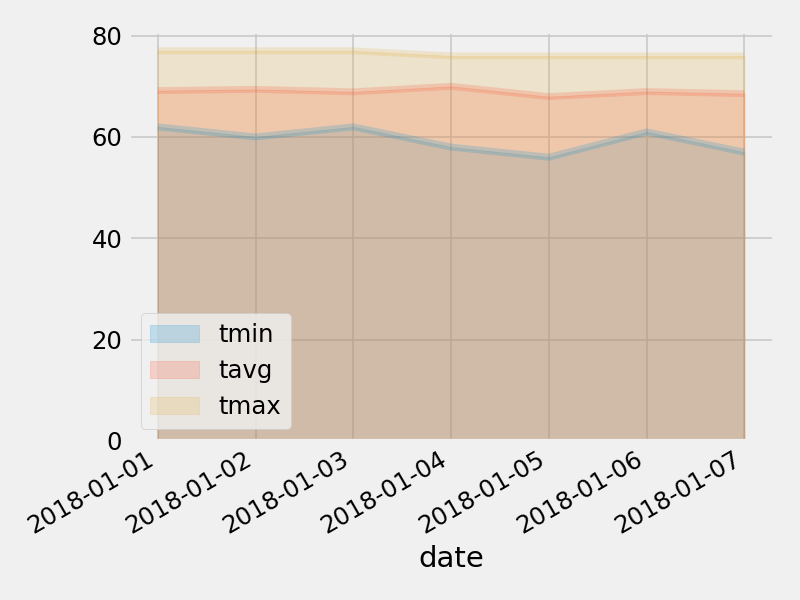

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
